## Importing Libraries

In [481]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import seaborn as sns


## Loading the Data

In [482]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [483]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

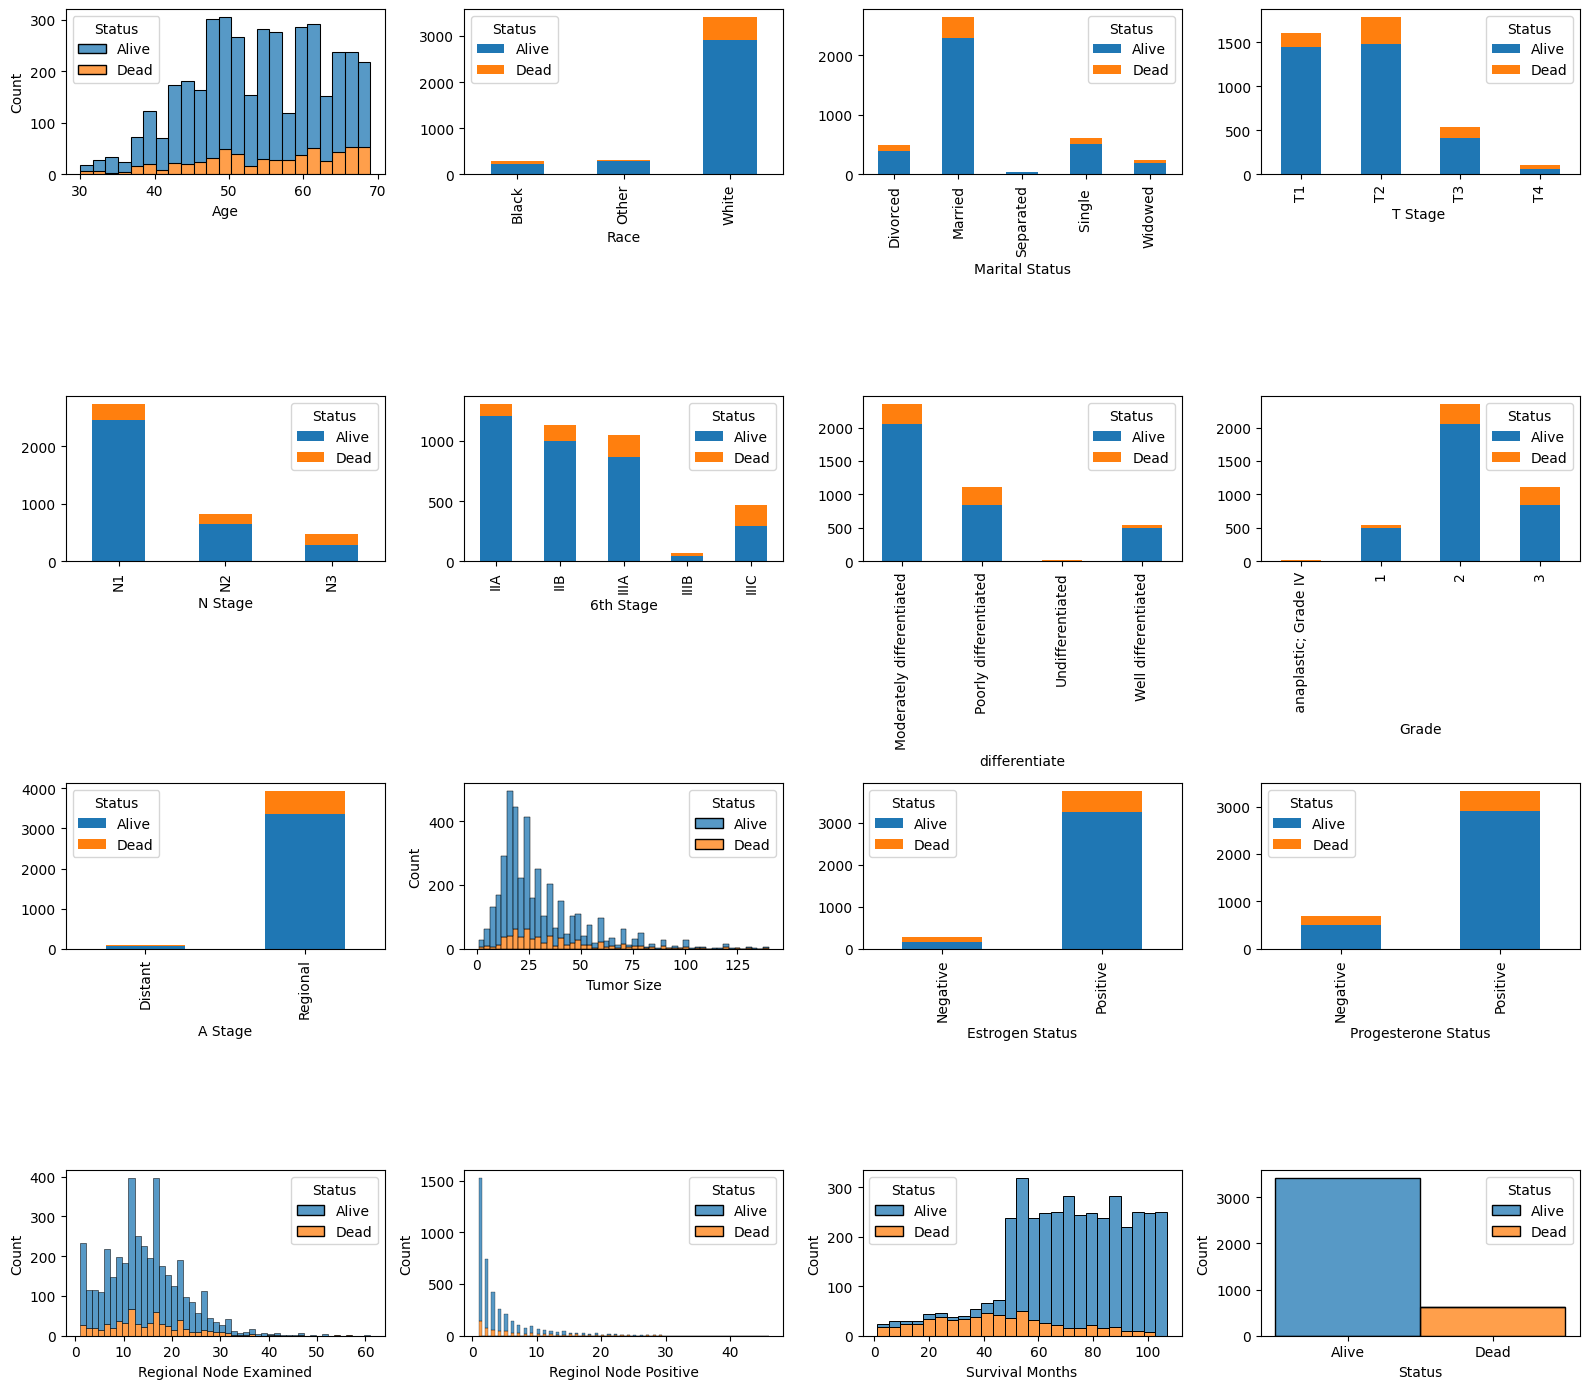

In [484]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

## Outlier Detection

<Axes: ylabel='Frequency'>

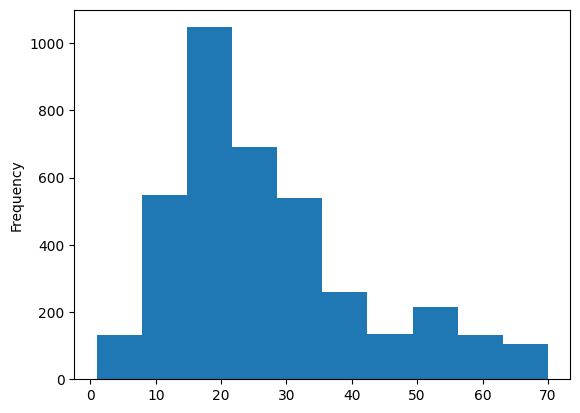

In [485]:
# Calculate the IQR range
Q1 = df['Tumor Size'].quantile(0.25)
Q3 = df['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = df[(df['Tumor Size'] < lower_bound) | (df['Tumor Size'] > upper_bound)]

# Remove outliers from 'Tumor Size'
df = df[(df['Tumor Size'] >= lower_bound) & (df['Tumor Size'] <= upper_bound)]

df['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

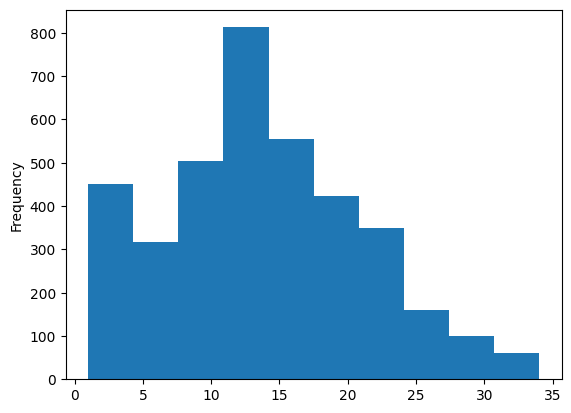

In [486]:
# Calculate the IQR range
Q1 = df['Regional Node Examined'].quantile(0.25)
Q3 = df['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = df[(df['Regional Node Examined'] < lower_bound) | (df['Regional Node Examined'] > upper_bound)]

# Remove outliers from 'Regional Node Examined'
df = df[(df['Regional Node Examined'] >= lower_bound) & (df['Regional Node Examined'] <= upper_bound)]

df['Regional Node Examined'].plot.hist()

## Train Test Split

In [488]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Preprocessing

In [489]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Data Balancing

In [490]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2044, 1: 347})


In [491]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1743, 0: 1377})


## Support Functions

In [492]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [493]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [494]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.849498,0.583333,0.488372,0.724138,0.411765


In [495]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.913720,0
1,-1.650962,0
2,-1.925434,0
3,-1.951632,0
4,-1.549215,0
...,...,...
3115,1.621268,1
3116,1.565855,1
3117,0.361068,1
3118,-0.081381,1


<Axes: xlabel='0'>

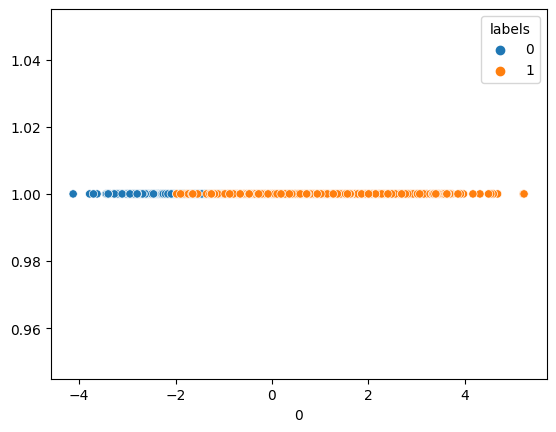

In [496]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [497]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   43  0.673913  0.388715  0.267241  0.712644  0.241245
      41  0.667224  0.383901  0.262712  0.712644  0.237548
      45  0.683946   0.38835   0.27027  0.689655  0.240964
      39  0.657191  0.369231  0.252101  0.689655  0.226415
      37  0.655518  0.368098  0.251046  0.689655  0.225564
      35  0.660535  0.367601  0.252137  0.678161  0.225191
      33  0.662207   0.36875  0.253219  0.678161  0.226054
      31  0.657191  0.365325      0.25  0.678161  0.223485
      49  0.670569  0.370607  0.256637  0.666667  0.227451
      47  0.682274  0.379085   0.26484  0.666667  0.233871
      27  0.683946  0.372093  0.261682  0.643678  0.228571
      29  0.662207  0.356688  0.246696  0.643678  0.217054
      25  0.680602  0.365449  0.257009  0.632184  0.223577
      23  0.677258  0.363036   0.25463  0.632184  0.221774
      21  0.672241  0.355263  0.248848   0.62069     0.2

In [498]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 43


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.849498,0.583333,0.488372,0.724138,0.411765
KNN-43,0.673913,0.388715,0.267241,0.712644,0.241245


## Logistic Regression

In [499]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.782609  0.514925  0.381215  0.793103  0.346734
       1.0       0.827759  0.569038  0.447368  0.781609  0.397661
       10.0      0.832776   0.57265  0.455782  0.770115  0.401198
       100000.0  0.831104  0.558952  0.450704  0.735632  0.387879
       10000.0   0.831104  0.558952  0.450704  0.735632  0.387879
       1000.0    0.831104  0.558952  0.450704  0.735632  0.387879
       100.0     0.829431  0.556522  0.447552  0.735632  0.385542


In [500]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.782609,0.514925,0.381215,0.793103,0.346734
LDA,0.849498,0.583333,0.488372,0.724138,0.411765
KNN-43,0.673913,0.388715,0.267241,0.712644,0.241245


## Random Forest

In [501]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.978766920264796


In [502]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.782609,0.514925,0.381215,0.793103,0.346734
LDA,0.849498,0.583333,0.488372,0.724138,0.411765
KNN-43,0.673913,0.388715,0.267241,0.712644,0.241245
Random Forest,0.82107,0.506912,0.423077,0.632184,0.339506


## Feature Importance

<Axes: >

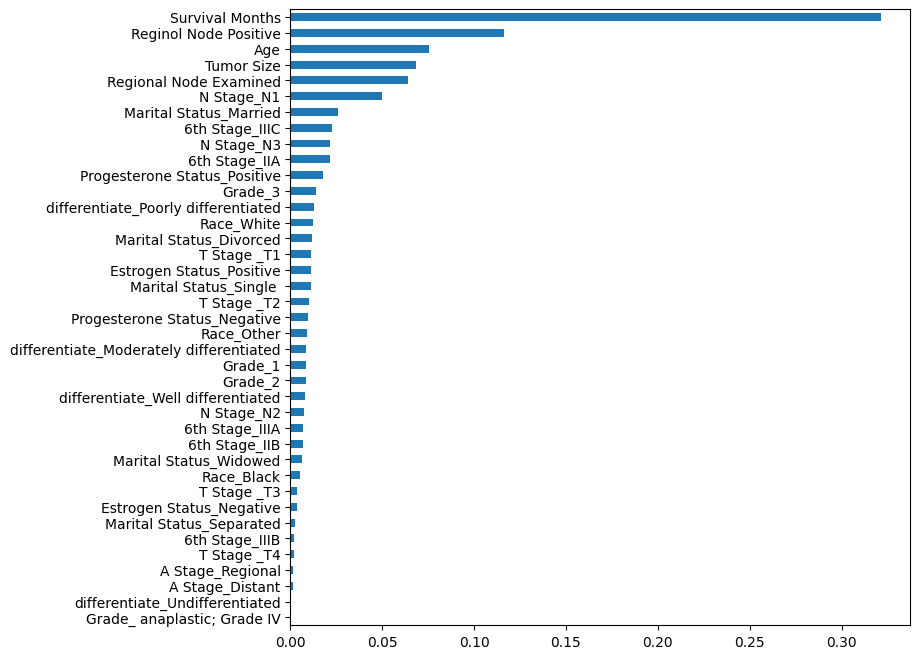

In [503]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [504]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [505]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7767379679144385
recall_score:  0.8165137614678899
jaccard_score:  0.34765625
f1_score:  0.5159420289855073
precision_score:  0.3771186440677966
